![](https://hsto.org/getpro/habr/post_images/68f/fc1/d69/68ffc1d69c10d1ede103288c779c8f4e.jpg) 

# Наша первая нейросеть в Keras 

Изначально Keras создавалася как удобная надстройка над Theano. Отсюда появилось такое греческой название пакета (переводится как "рог"), ставшее отсылкой к Одиссее Гомера. Сегодня Keras поддерживает второй знаменитый фрэймворк Tensorflow, созданный Google и использует кго в качестве базового. 

## 1. О задаче, которую мы будем решать

Для своего первого знакомства с нейросетками, мы будем использовать встроенный датасет под названием `boston_housing`. Как это не удивительно, речь пойдёт о недвижимости и ценах на неё. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
from keras.datasets import boston_housing
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

Using TensorFlow backend.


In [3]:
X_train.shape

(404, 13)

In [4]:
X_test.shape

(102, 13)

Проскалируем переменные.

In [5]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()
X_train = scl.fit_transform(X_train)
X_test = scl.transform(X_test)

## 2. Регрессия - моя профессия 

Оцените уже давно и до боли нам знакомую линейную регрессию. Посмотрите на качество модели. Прикрутите к ней $l_2$-регуляризатор, подберите оптимальное значение для гиерпараметра с помощью `greadsearch`. Посмотрите на качество модели. В качестве метрики используйте $MSE$. 

In [6]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer

scorer = make_scorer(mean_squared_error, 
                     greater_is_better=False)

parameters = {'alpha': np.power(10, np.linspace(-3, 3, 7))}

grid = GridSearchCV(Ridge(random_state=7), 
                    parameters, 
                    cv=5, 
                    scoring=scorer)

grid.fit(X_train, y_train)

print('Лучшая модель: ', grid.best_estimator_)

Лучшая модель:  Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=7, solver='auto', tol=0.001)


In [7]:
print('Параметры лучшей модели: ', grid.best_estimator_.coef_)

Параметры лучшей модели:  [-1.09617853e+00  1.33240158e+00  2.36163129e-03  9.96960412e-01
 -2.36364456e+00  2.41020778e+00  2.00070026e-01 -3.43427327e+00
  2.81042350e+00 -1.86812093e+00 -1.97196416e+00  8.20257578e-01
 -4.00831026e+00]


In [8]:
print('MSE: ', mean_squared_error(y_test, grid.best_estimator_.predict(X_test)))

MSE:  23.105483040456594


## 3. Нейросеть - регрессия

Как это не удивительно, линейная регрессия это частный, самый простой случай нейросети. Постройте в keras нейросеть из одного нейрона. Обучите её. Посмотрите на качество, сравните с обычной регрессией. 

In [10]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5)

model = Sequential()
model.add(Dense(1, 
                input_dim=X_train.shape[1], 
                kernel_initializer='random_normal'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(X_train, y_train, epochs=1000, verbose=0, validation_split=0.2, callbacks=[es])

In [13]:
model.evaluate(X_test, y_test)

102/102 [==============================] - 0s 53us/step


97.11970714494294

Прикрутите к сетке [регуляризатор.](https://keras.io/regularizers/) Посмотрите на качество модели.

In [15]:
from keras import regularizers

model = Sequential()
model.add(Dense(1, 
                input_dim=X_train.shape[1], 
                kernel_regularizer=regularizers.l2(1.0),
                kernel_initializer='random_normal'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
model.fit(X_train, y_train, epochs=10000, verbose=0, validation_split=0.2, callbacks=[es])

In [20]:
model.evaluate(X_test, y_test)

102/102 [==============================] - 0s 56us/step


40.85035421334061

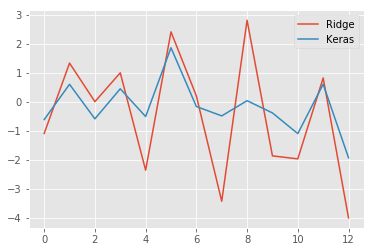

In [21]:
plt.plot(grid.best_estimator_.coef_, label='Ridge')
plt.plot(model.get_weights()[0], label='Keras')
plt.legend()
plt.show()

## 4. Один слой и оптимальное число нейронов 

**Итак, небольшое задание для самостоятельной работы.**

Постройте нейронную сеть с одним скрытым слоем. Постройте для неё картинку с зависимостью качества модели от числа используемых в сети нейронов на обучении и тесте. По оси $x$ отложите число нейронов, используемое в слое. По оси $y$ качество модели. Для борьбы с переобучением используйте early stopping. Число нейронов перебирайте от $1$ до $20$. Запаситесь терпением и не забудьте проинтерпретировать картинки.

In [22]:
from tqdm import tqdm_notebook

alpha = 1
train_score = []
test_score = []

for neurons in tqdm_notebook(range(1, 21)):
    
    model = Sequential()
    model.add(Dense(neurons, 
                    input_dim=X_train.shape[1], 
                    kernel_regularizer=regularizers.l2(alpha),
                    kernel_initializer='random_normal'))
    
    model.add(Dense(1, 
                    input_dim=neurons, 
                    kernel_regularizer=regularizers.l2(alpha), 
                    kernel_initializer='random_normal'))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=1000, verbose=0, validation_split=0.2, callbacks=[es])
    
    train_score.append(model.evaluate(X_train, y_train))
    test_score.append(model.evaluate(X_test, y_test))

HBox(children=(IntProgress(value=0, max=20), HTML(value='')))

102/102 [==============================] - 0s 47us/step



In [ ]:
plt.plot(np.arange(1, 21), train_score, label='train score')
plt.plot(np.arange(1, 21), test_score, label='test score')
plt.title('MSE от числа нейронов в скрытом слое')
plt.xlabel('число нейронов')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 5. Больше слоёв

Попробуйте построит двух и трёх-слойные сетки с разным числом нейронов. Попробуйте добиться максимально возможного качества. Обратите внимание, что данных у нас очень мало, нейронка будем маленькой и быстро оцениваимой. Это позволяет делать перебор гиперпараметров. Когда данных очень много, перебор - довольно сложная штука. 

In [ ]:
# исследование модели с 2 скрытыми слоями
train_score = []
test_score = []

for alpha in [0.01, 0.1, 1, 5]:
    print('alpha =', alpha)
    for neurons_l1 in [1, 3, 10, 20]:
        for neurons_l2 in [1, 3, 10, 20]:
            model = Sequential()
            model.add(Dense(neurons_l1, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(alpha), kernel_initializer='random_normal'))
            model.add(Dense(neurons_l2, input_dim=neurons_l1, kernel_regularizer=regularizers.l2(alpha), kernel_initializer='random_normal'))
            model.add(Dense(1, input_dim=neurons_l2, kernel_regularizer=regularizers.l2(alpha), kernel_initializer='random_normal'))

            model.compile(optimizer='adam', loss='mean_squared_error')
            model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[es], validation_split=0.2)

            train_score.append(model.evaluate(X_train, y_train))
            test_score.append(model.evaluate(X_test, y_test))

In [ ]:
plt.plot(train_score, label='train score')
plt.plot(test_score, label='test score')
plt.legend()
plt.show()

print(min(test_score))

In [ ]:
# исследование модели с 3 скрытыми слоями
train_score = []
test_score = []
best_mse = 1000
best_model = None

for alpha in [0.01, 0.1, 1, 5]:
    print('alpha =', alpha)
    for neurons_l1 in [1, 3, 10, 20]:
        for neurons_l2 in [1, 3, 10, 20]:
            for neurons_l3 in [1, 3, 10, 20]:
                model = Sequential()
                model.add(Dense(neurons_l1, input_dim=X_train.shape[1], kernel_regularizer=regularizers.l2(alpha), kernel_initializer='random_normal'))
                model.add(Dense(neurons_l2, input_dim=neurons_l1, kernel_regularizer=regularizers.l2(alpha), kernel_initializer='random_normal'))
                model.add(Dense(neurons_l3, input_dim=neurons_l2, kernel_regularizer=regularizers.l2(alpha), kernel_initializer='random_normal'))
                model.add(Dense(1, input_dim=neurons_l2, kernel_regularizer=regularizers.l2(alpha)))

                model.compile(optimizer='adam', loss='mean_squared_error')
                model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[es], validation_split=0.2)

                train_score.append(model.evaluate(X_train, y_train))
                test_score.append(model.evaluate(X_test, y_test))
                
                if test_score[-1] < best_mse:
                    best_mse = test_score[-1]
                    best_model = model

In [ ]:
plt.plot(train_score, label='train score')
plt.plot(test_score, label='test score')
plt.legend()
plt.show()

In [ ]:
print(min(test_score))
print(best_model.summary())

In [ ]:
# Ваш код 